In [33]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
%autoreload 2

import pandas as pd, numpy as np
import os, glob, re, sys, time
sys.path.append("..")

from project.apps.bidinterpreter.doctools import DocTools

%matplotlib inline

Test specific document 

In [95]:
dt = DocTools(use_django_paths = False)  # this is the new class for general document handling which may be expanded to more than just "PDFs"

filename            =  "processed/Waterford Place JPM LOI 101129.pdf"
source_path         =  f"{os.getcwd()}/processed"

# img_filepath        =   dt.pdf_to_image(filename, source_path)        # 1. Converts initial PDF doc to image, returns image location
# pdf_filepath        =   dt.image_to_pdf(img_filepath)                 # 2. Converts image to "searchable pdf"
# doctext, vocabulary =   dt.pdf_to_text_coordinates(pdf_filepath)      # 3. Get document text from PDF, then get coordinates of each word
# matches           =   dt.get_entity_matches(doctext, vocabulary)  # 4. Extract matches /w coordinates
# dt.image_to_highlighted(matches, pdf_filepath, img_filepath)        # 5. Apply highlighting to document and save PNG
pdf_filepath = "processed/Waterford Place JPM LOI 101129.pdf.png.processed.pdf"
matches      =   dt.map_entities(pdf_filepath, vocabulary)
print(matches)


setting use_django_paths False
[{'index': 16, 'entity_name': 'purchaseprice', 'entity_value': '$106,500,000', 'x0': Decimal('453.621'), 'x1': Decimal('654.123'), 'y0': Decimal('1168.776'), 'y1': Decimal('1153.273')}, {'index': 5, 'entity_name': 'deposit', 'entity_value': '$2,000,000', 'x0': Decimal('250.987'), 'x1': Decimal('411.418'), 'y0': Decimal('3209.713'), 'y1': Decimal('3194.892')}]


In [24]:
pdf_filepath

'processed/Waterford Place JPM LOI 101129.pdf.png.processed.pdf'

## Process Documents and Collect Data
This process is more or less what our Django webapp uses for processing documents.  On ~300 documents, this takes about 1.5-2 hours on a machine with 4 cores, 16GB ram, and a very fast solid state drive running Ubuntu Linux.  After you run this frame, watch it for about 15-20 minutes, then its safe to let it run in the background.

### Setup PDF Directory
This notebook assumes that there is a "processed" folder in the same directory as this notebook.  This directory isn't checked into the repository so you will have to manually create it and put PDFs into it.

In [ ]:
dt = DocTools(use_django_paths = False)  # this is the new class for general document handling which may be expanded to more than just "PDFs"

pdf_directory = "processed/*.pdf"
# source_path = os.getcwd() + "/images"
source_path = f"{os.getcwd()}/processed"

filtered = [
    file for file in glob.iglob(pdf_directory, recursive=True) # find all files in uploads directory
    if re.search(".+pdf$", file) and "png" not in file         # filter to files with pdf extension but not having the PNG files (original, unprocessed docs)
]

matched_data = []

for filename in filtered:
    start_time = time.time()
    print(f"Processing {filename}...")
    try:
        img_filepath        =   dt.pdf_to_image(filename, source_path)        # 1. Converts initial PDF doc to image, returns image location
        pdf_filepath        =   dt.image_to_pdf(img_filepath)                 # 2. Converts image to "searchable pdf"
        doctext, vocabulary =   dt.pdf_to_text_coordinates(pdf_filepath)      # 3. Get document text from PDF, then get coordinates of each word
        # matches             =   dt.get_entity_matches(doctext, vocabulary)  # 4. Extract matches /w coordinates
        # dt.image_to_highlighted(matches, pdf_filepath, img_filepath)        # 5. Apply highlighting to document and save PNG
        matches             =   dt.map_entities(pdf_filepath, vocabulary)
        if not matches:
            matches = [{}]
        for index, match in enumerate(matches):
            if not match:
                matches[index] = {}
            matches[index]['document']     = filename
            matches[index]['process_time'] = time.time() - start_time
    except Exception as e:
        matches = [{
            'document':   filename,
            'error':      e.message, 
            'error_args': e.args
        }]
        
    
    matched_data.append(matches)
    print("Done.")

setting use_django_paths False
Processing processed/010 400 Divisadero SHAC LOI 09.10.18.pdf...
2020-09-02 18:47:31,393 - doctools - INFO - Converting processed/010 400 Divisadero SHAC LOI 09.10.18.pdf
2020-09-02 18:47:31,393 - doctools - INFO - Converting processed/010 400 Divisadero SHAC LOI 09.10.18.pdf
2020-09-02 18:47:31,393 - doctools - INFO - Converting processed/010 400 Divisadero SHAC LOI 09.10.18.pdf
2020-09-02 18:47:31,393 - doctools - INFO - Converting processed/010 400 Divisadero SHAC LOI 09.10.18.pdf
2020-09-02 18:47:31,393 - doctools - INFO - Converting processed/010 400 Divisadero SHAC LOI 09.10.18.pdf
2020-09-02 18:47:31,393 - doctools - INFO - Converting processed/010 400 Divisadero SHAC LOI 09.10.18.pdf
2020-09-02 18:47:31,393 - doctools - INFO - Converting processed/010 400 Divisadero SHAC LOI 09.10.18.pdf
2020-09-02 18:47:31,393 - doctools - INFO - Converting processed/010 400 Divisadero SHAC LOI 09.10.18.pdf
2020-09-02 18:47:31,393 - doctools - INFO - Converting p

## Create DataFrame from matched results

### Format Data

In [100]:
# matched_data 

In [101]:
formatted = []
for match in matched_data:
    record = {}
    for entity in match:
        record['document']     = entity.get('document', np.nan).split("/")[::-1][0]
        record['process_time'] = entity.get('process_time', np.nan)
        entity_name = entity.get('entity_name', np.nan)
        if entity_name:
            record[entity_name]    = entity.get('entity_value', np.nan)

    formatted.append(record)

### Create DataFrame From Formatted Data

In [102]:
df = pd.DataFrame(formatted)
df

document  process_time  \
0            010 400 Divisadero SHAC LOI 09.10.18.pdf     16.645866   
1         010 AvalonBay LOI - Gateway - 2019-11-7.pdf     18.360690   
2            010 Cambridge Capital LOI 2016-04-07.pdf     16.358829   
3    010 DR Horton LOI Crescent Heights 2017-11-1.pdf      7.290237   
4                    010 Dutchints LOI 2018-11-17.pdf     17.775454   
..                                                ...           ...   
334                Waterford Place JPM LOI 101129.pdf     10.721896   
335                Waterford Place JPM LOI 101202.pdf     10.530183   
336           Waterford Place Signed LOI 12-15-10.pdf     22.383283   
337           Waterford Place UBS LOI (12.2.2010).pdf     25.880162   
338                          Waterton LOI 8-28-12.pdf     19.108495   

    purchaseprice  NaN       time_period           closing     deposit  \
0             $33  NaN          40 years               NaN         NaN   
1             NaN  NaN          one year           30 days    $500,000   
2             NaN  NaN               NaN               NaN  $3,800,000   
3        $111,000  NaN           60 days  10 business days    $100,000   
4             NaN  NaN         12 months               NaN         NaN   
..            ...  ...               ...               ...         ...   
334  $106,500,000  NaN               NaN               NaN  $2,000,000   
335  $113,000,000  NaN               NaN               NaN  $2,000,000   
336           NaN  NaN  two business day               NaN         NaN   
337  $113,000,000  NaN  one business day               NaN         NaN   
338           NaN  NaN            14 day               NaN         NaN   

                   dd  
0                 NaN  
1                 NaN  
2                 NaN  
3             60 days  
4                 NaN  
..                ...  
334               NaN  
335               NaN  
336  21 business days  
337               NaN  
338               NaN  

[339 rows x 8 columns]

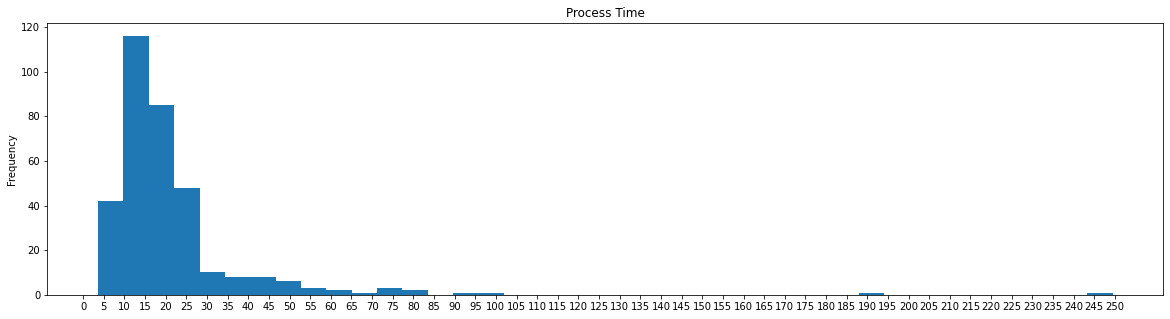

In [103]:
import matplotlib.pyplot as plt

ax = df['process_time'].plot(kind = "hist", title = "Process Time", bins = 40, figsize = (20, 5))
plt.xticks(np.arange(0, df['process_time'].max()+1, 5.0));

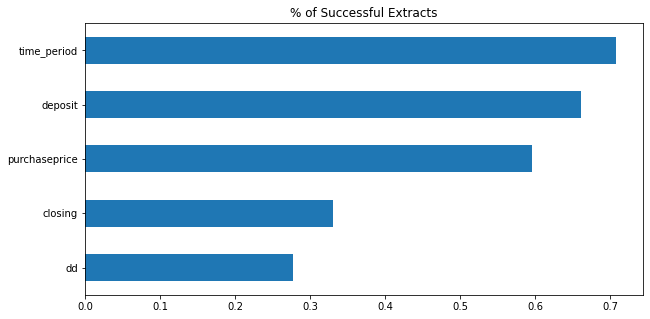

In [104]:
features = ['closing', 'deposit', 'time_period', 'purchaseprice', 'dd']
(df[features].count() / df[features].shape[0]).sort_values().plot(kind="barh", title="% of Successful Extracts", figsize= (10, 5))

### Save results to CSV / comma delimited file.

In [105]:
df.to_csv("matching_stats-09-02-2020.csv", encoding="utf-8")

In [4]:
df = pd.read_csv("matching_stats-08-31-2020.csv")

In [12]:
df[df['purchaseprice'].isnull()].to_csv("no_purchase_price.csv", encoding="utf8")

In [14]:
df[df['purchaseprice'].isnull()]

Unnamed: 0                                     document  process_time  \
0             0     010 400 Divisadero SHAC LOI 09.10.18.pdf     15.670794   
1             1  010 AvalonBay LOI - Gateway - 2019-11-7.pdf     17.088694   
2             2     010 Cambridge Capital LOI 2016-04-07.pdf     15.842535   
4             4             010 Dutchints LOI 2018-11-17.pdf     17.558422   
6             6             010 Fairfield LOI - 10-18-11.pdf     18.472832   
..          ...                                          ...           ...   
334         334           Waterford Place JPM LOI 101129.pdf      9.557956   
335         335           Waterford Place JPM LOI 101202.pdf      9.840634   
336         336      Waterford Place Signed LOI 12-15-10.pdf     20.233382   
337         337      Waterford Place UBS LOI (12.2.2010).pdf     23.952720   
338         338                     Waterton LOI 8-28-12.pdf     17.609925   

     Unnamed: 3       time_period  closing     deposit purchaseprice  \
0           NaN          40 years      NaN         NaN           NaN   
1           NaN          one year  30 days    $500,000           NaN   
2           NaN               NaN      NaN  $3,800,000           NaN   
4           NaN               NaN      NaN         NaN           NaN   
6           NaN           30 days      NaN         NaN           NaN   
..          ...               ...      ...         ...           ...   
334         NaN               NaN      NaN         NaN           NaN   
335         NaN               NaN      NaN         NaN           NaN   
336         NaN  two business day      NaN         NaN           NaN   
337         NaN  one business day      NaN         NaN           NaN   
338         NaN            14 day      NaN         NaN           NaN   

                   dd  
0                 NaN  
1                 NaN  
2                 NaN  
4                 NaN  
6                 NaN  
..                ...  
334               NaN  
335               NaN  
336  21 business days  
337               NaN  
338               NaN  

[237 rows x 9 columns]